If Dockerfiles have not been modified, connect to the Jupyter server with ```http://localhost:8009/tree?token=cluster-data```.  

This notebook provides an interface to perform k-means clustering on a dataset of n×1 matrices, each represented as a ```.json```.  

In [1]:
target_dir = "data"
input_dir = "thomson-perceptions"
output_dir = "thomson-perceptions-clustering"
data_type = "perceptions"

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import json
import os
from pathlib import Path

In [3]:
datas_path = []
for dirpath, dirnames, filenames in os.walk(os.path.join(target_dir, input_dir)):
    datas_path.extend(filenames)
    break
datas_id = {}
for data_path in datas_path:
    with open(os.path.join(target_dir, input_dir, data_path), 'r') as fp:
        datas_id['.'.join(data_path.split('.')[:-1])] = json.load(fp)
datas_df = pd.DataFrame.from_dict(datas_id, orient='index').reset_index(names="id")
datas_df.head()

cluster_df = pd.DataFrame(datas_df["id"])

In [4]:
X = datas_df.drop("id", axis=1).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Path(os.path.join(target_dir, output_dir)).mkdir(parents=True, exist_ok=True)
with open(os.path.join(target_dir, output_dir, f"scaler-{data_type}.pkl"), "wb") as fp:
    joblib.dump(scaler, fp)

# pca = PCA(12)
# X_pca = pca.fit_transform(X_scaled)
# print(sum(pca.explained_variance_ratio_))
# Path(os.path.join(target_dir, output_dir)).mkdir(parents=True, exist_ok=True)
# with open(os.path.join(target_dir, output_dir, f"pca-{data_type}.pkl"), "wb") as fp:
#     joblib.dump(pca, fp)

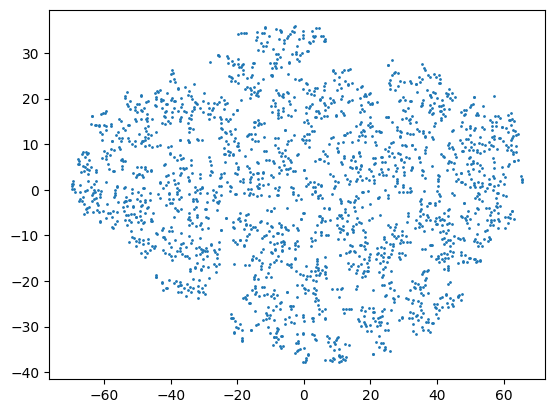

In [8]:
test_tsne = TSNE(n_components=2, random_state=0)
X_test_tsne = test_tsne.fit_transform(X)
cluster_df[['x', 'y']] = X_test_tsne
plt.scatter(x=cluster_df['x'], y=cluster_df['y'], s=1)
plt.show()

In [6]:
# hdbscan = HDBSCAN(min_cluster_size=10, min_samples=1, store_centers="centroid")
# hdbscan.fit(X)
# X_hdbscan = X
# n_clusters = len(set(hdbscan.labels_))

In [7]:
# print(set(hdbscan.labels_))

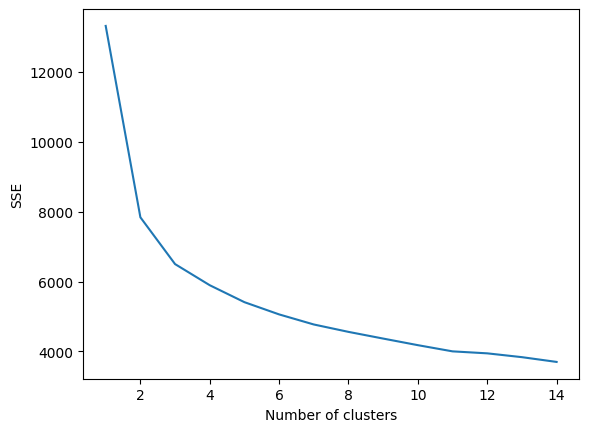

In [12]:
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=2000, random_state=0).fit(X_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [25]:
n_clusters = 11

In [26]:
kmeans = KMeans(n_clusters=n_clusters, max_iter=2000, random_state=0)
X_kmeans = kmeans.fit_transform(X_scaled)
cluster_df["cluster"] = kmeans.labels_

Path(os.path.join(target_dir, output_dir)).mkdir(parents=True, exist_ok=True)
with open(os.path.join(target_dir, output_dir, f"kmeans-{data_type}.pkl"), "wb") as fp:
    joblib.dump(kmeans, fp)

In [27]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_kmeans)
cluster_df[['x', 'y']] = X_tsne

Path(os.path.join(target_dir, output_dir)).mkdir(parents=True, exist_ok=True)
with open(os.path.join(target_dir, output_dir, f"tsne-{data_type}.pkl"), "wb") as fp:
    joblib.dump(tsne, fp)
with open(os.path.join(target_dir, output_dir, f"clustering-{data_type}.csv"), 'w') as fp:
    cluster_df.to_csv(fp, index=False)

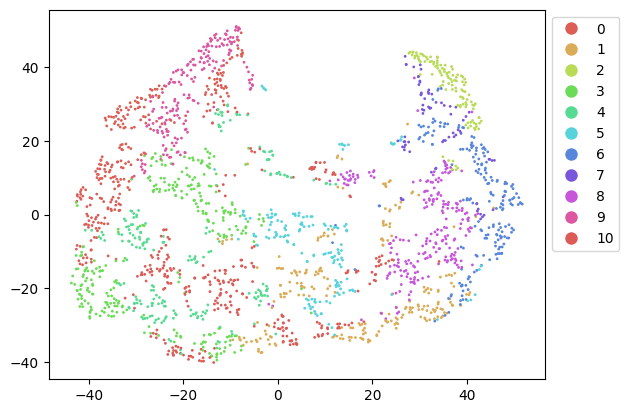

In [28]:
cmap = sns.color_palette("hls", n_clusters, as_cmap=True)
plt.scatter(x=cluster_df['x'], y=cluster_df['y'], s=1, c=kmeans.labels_, cmap=cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / (n_clusters - 1)), markersize=10, label=i) for i in range(n_clusters)]
plt.legend(handles=handles, bbox_to_anchor=(1, 1))
plt.show()

In [29]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32),
 array([273, 230, 113, 296, 200, 161, 191,  75, 225, 190, 264]))